### Twitter Hate Speech

For this effort, we will be investigating the content of tweets (Twitter posts) and determining if their content can be considered hateful, offensive, or neither. We will be employing a supervised Logistic Regression model and an unsupervised learning K-Means Clustering model.

### Feature Exploration
1. `Index` (`Unnamed: 0`) : unique identifier for each entry
2. `count` : number of users who coded each tweet (min is 3; sometimes more users coded a tweet when judgments were determined to be unreliable by CF)
3. `hate_speech` : number of users who judged the tweet to be hate speech
4. `offensive_language` : number of CF users who judged the tweet to be offensive
5. `neither` : number of users who judged the tweet to be neither offensive nor non-offensive
6. `class` : label for the majority of users. 0 - hate speech 1 - offensive language 2 - neither
7. `tweet` : actual tweet text

### Code

In [4]:
import pandas as pd

# Load data in and see what we're working with
df = pd.read_csv("labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


It appears as if there are seven columns in this dataset. However, I think there are only five features for our one target variable, which is the `class` of a tweet. The unique identifier (currently called `Unnamed:0`) for each tweet will not be influencing the classification of an entry. It seems like the problem that we are trying to solve here is predicing the classification of a tweet, whether it be hate speech, offensive language, or neither. Before I explore the individual features a bit more, I am going to rename the first column to be a little more accurate.

In [6]:
df.rename(columns={"Unnamed: 0": "Id"}, inplace=True)
df.head()

,Id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Looks like the change of column 1 was successful. Let's see if there is any missing data we need to worry about.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


There are 24,378 entries in this dataset and there is no missing data in any of the columns. I am going to check out the value counts of each feature to see if they should be treated as categorical or numerical.

In [10]:
df['count'].value_counts()

count
3    22807
6     1571
4      211
9      167
7       27
Name: count, dtype: int64

Although this variable is represented by integers, I do not think it should be treated as numerical. There are only five possible values for the `count` feature, so I am going to move forward with it as categorical. Maybe I end up changing my mind, maybe not.

In [12]:
df['hate_speech'].value_counts()

hate_speech
0    19790
1     3419
2     1251
3      287
4       21
5        7
6        5
7        3
Name: count, dtype: int64

Same with the `hate_speech` feature here. There are only eight possible values for the `hate_speech` feature, so I do not think it can be treated as numerical. This is kind of similar to the Titanic dataset that used integers to represent number of siblings and children on board, but they were actually categorical variables.

In [14]:
df['offensive_language'].value_counts()

offensive_language
3    13383
2     4246
0     3475
1     2066
6      857
5      369
4      251
9       66
8       37
7       33
Name: count, dtype: int64

I am a little unsure about the `offensive_language` feature too, but I am going to say it is a categorical feature.

In [16]:
df['neither'].value_counts()

neither
0    18892
3     2790
1     1694
2     1200
6      103
5       54
4       35
9        5
8        5
7        5
Name: count, dtype: int64

Also am a little unsure about the `neither` feature too, but I am going to say it is a categorical feature.

In [18]:
df['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

`Class` is our target variable for this scenario and should definitely be treated as a categorical variable. Let's check out the distribution of it with a histogram, as opposed to just looking at the value counts.

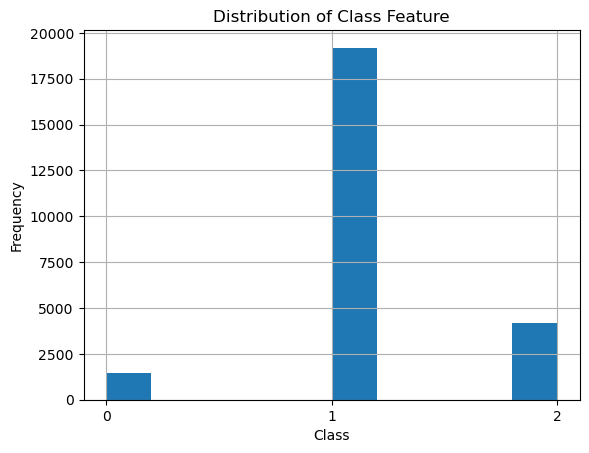

In [20]:
import matplotlib.pyplot as plt

df['class'].hist()
plt.title('Distribution of Class Feature')
plt.xlabel('Class')
plt.xticks([0, 1, 2])
plt.ylabel('Frequency')
plt.show()

The overwhelming majority (~77%) of tweets in this dataset have been given a classification of 1, which corresponds to containing offensive language. Unfortunately, we have not been given any information regarding the criteria for how a tweet is classified. However, I think we can assume there is a threshold that needs to be hit for the number of users that find a tweet containing offensive language or hate speech. Maybe that threshold is just one person?

### Tokenization

First, we need to do some preprocessing of the text data in the `tweet` column of our dataset. Due to my background knowledge of Twitter, I know that we will have to take into account various symbols, like hashtags, at signs (@), punctuation, ampersands, etc. User names are typically represented in the format of '@user_name' and can possibly contain offensive text within itself. So, I think I am going to remove all these symbols from the text data, but keep the user names that follow. I am aware that we may lose some context and understanding of the individual tweets by removing these symbols, but the main objective of classifying tweets that contain offensive text will not be affected. The same point goes with website URLs and links that are represented as 'https://some-website'. We may lose some context of an individual tweet, but the offensive speech should be contained within the text of the tweet, not a URL link or user name. 

### Feature Extraction

Let's start cleaning up the `tweets` column. I am going to keep the original dataset, but then make another dataframe consisting of the tweets after the preprocessing/cleaning steps. I am going to eventually remove symbols, URLs, punctuation, capitalization, and stop words. First, we need to download the Natural Language Toolkit to implement the removal of stopwords. 

In [26]:
# Get NLTK package in here
import nltk

In [27]:
# Get stop words from NLTK package
stop_words = nltk.corpus.stopwords.words("english")

# Not too familiar with what stop words are, so lets check those out
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

After some googling, I've learned that stop words are just commonly used words that search engines are programmed to ignore. Basically, stop words are just "fluff" that we do not want taking up space because there is not much to gain from keeping them. In the context of this problem, these stop words would not be helping us identify which tweets contained offensive text, so let's just get rid of them. Also, some of these stop words contain apostrophes that we would be removing anyways.

In [29]:
# Make new dataframe to preserve original dataset
cleaned_df = df.copy()

In [30]:
# Rename tweets column
cleaned_df.rename(columns={"tweet": "cleaned_tweet"}, inplace=True)
cleaned_df.head()

,Id,count,hate_speech,offensive_language,neither,class,cleaned_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


After looking at some of the tweets in this dataset, we probably want to add 'retweet' and 'rt' to list of stop words to eventually be removed.

In [32]:
more_stop_words = ['rt', 'retweet']
stop_words.extend(more_stop_words)

# Ensure additional words were successfully added
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Now that we have our "experimental" dataset and additional stop words, let's begin cleaning up the text data of these tweets. We'll start this process by lowercasing all the text and tokenizing the tweets.

In [34]:
# Make all text lowercase
tweets_to_clean = cleaned_df.cleaned_tweet
lowercase_text = tweets_to_clean.str.lower()

# Tokenize text
from nltk.tokenize import word_tokenize
tokenized_text = lowercase_text.apply(word_tokenize)
print(tokenized_text)

0        [!, !, !, rt, @, mayasolovely, :, as, a, woman...
1        [!, !, !, !, !, rt, @, mleew17, :, boy, dats, ...
2        [!, !, !, !, !, !, !, rt, @, urkindofbrand, da...
3        [!, !, !, !, !, !, !, !, !, rt, @, c_g_anderso...
4        [!, !, !, !, !, !, !, !, !, !, !, !, !, rt, @,...
                               ...                        
24778    [you, 's, a, muthaf, *, *, *, in, lie, &, #, 8...
24779    [you, 've, gone, and, broke, the, wrong, heart...
24780    [young, buck, wan, na, eat, !, !, .., dat, nig...
24781        [youu, got, wild, bitches, tellin, you, lies]
24782    [~~ruffled, |, ntac, eileen, dahlia, -, beauti...
Name: cleaned_tweet, Length: 24783, dtype: object


Looks like we now have everything in lowercase format and the strings are split up based upon the spaces in the text data. Let's remove the stop words from this text data. 

In [36]:
# Remove stop words from tokenized text data
tokenized_text = tokenized_text.apply(lambda x: [item for item in x if item not in stop_words])
print(tokenized_text)

0        [!, !, !, @, mayasolovely, :, woman, n't, comp...
1        [!, !, !, !, !, @, mleew17, :, boy, dats, cold...
2        [!, !, !, !, !, !, !, @, urkindofbrand, dawg, ...
3        [!, !, !, !, !, !, !, !, !, @, c_g_anderson, :...
4        [!, !, !, !, !, !, !, !, !, !, !, !, !, @, she...
                               ...                        
24778    ['s, muthaf, *, *, *, lie, &, #, 8220, ;, @, l...
24779    ['ve, gone, broke, wrong, heart, baby, ,, drov...
24780    [young, buck, wan, na, eat, !, !, .., dat, nig...
24781             [youu, got, wild, bitches, tellin, lies]
24782    [~~ruffled, |, ntac, eileen, dahlia, -, beauti...
Name: cleaned_tweet, Length: 24783, dtype: object


In this initial step of cleaning up the text data, we were able to tokenize the text strings, convert to lowercase format, and successfully removed any stop words. Let's overwrite the data currently in the dataframe with this cleaned up, tokenized text data and move on.

In [38]:
cleaned_df['cleaned_tweet'] = tokenized_text
print(cleaned_df.head())

   Id  count  hate_speech  offensive_language  neither  class  \
0   0      3            0                   0        3      2   
1   1      3            0                   3        0      1   
2   2      3            0                   3        0      1   
3   3      3            0                   2        1      1   
4   4      6            0                   6        0      1   

                                       cleaned_tweet  
0  [!, !, !, @, mayasolovely, :, woman, n't, comp...  
1  [!, !, !, !, !, @, mleew17, :, boy, dats, cold...  
2  [!, !, !, !, !, !, !, @, urkindofbrand, dawg, ...  
3  [!, !, !, !, !, !, !, !, !, @, c_g_anderson, :...  
4  [!, !, !, !, !, !, !, !, !, !, !, !, !, @, she...  


We need to keep in mind that there must be a sweet spot between cleaning too much, losing information, and cleaning too little, passing the burden to the classification algorithm. We are not done cleaning, as there are still punctuation symbols, numbers, and URLs in the text data. Let's start by removing the punctuation, symbols, and numbers. Also, we can remove any tokens that are shorter than two characters in the same function call.

In [41]:
# Helper function to remove symbols, punctuation, and numbers
def filter_tokens(tokens):
    return [token for token in tokens if token.isalpha() and len(token) > 1 and token != 'http']

cleaned_df['cleaned_tweet'] = cleaned_df['cleaned_tweet'].apply(filter_tokens)
print(cleaned_df.head())

   Id  count  hate_speech  offensive_language  neither  class  \
0   0      3            0                   0        3      2   
1   1      3            0                   3        0      1   
2   2      3            0                   3        0      1   
3   3      3            0                   2        1      1   
4   4      6            0                   6        0      1   

                                       cleaned_tweet  
0  [mayasolovely, woman, complain, cleaning, hous...  
1  [boy, dats, cold, tyga, dwn, bad, cuffin, dat,...  
2  [urkindofbrand, dawg, ever, fuck, bitch, start...  
3                               [look, like, tranny]  
4  [shenikaroberts, shit, hear, might, true, migh...  


Looks like there are no more numbers, symbols, or URLs in our text data. Also, all of the tokens that are deemed too short have been removed. The user names are still in the data set, but that is by intention. We are done with the preprocessing of the text data. I found some cool examples of WordClouds online, so let's apply that to our dataset and see what words or tokens appear the most frequently throughout the dataset. Due to the nature of the text data, these will probably be fairly vulgar.

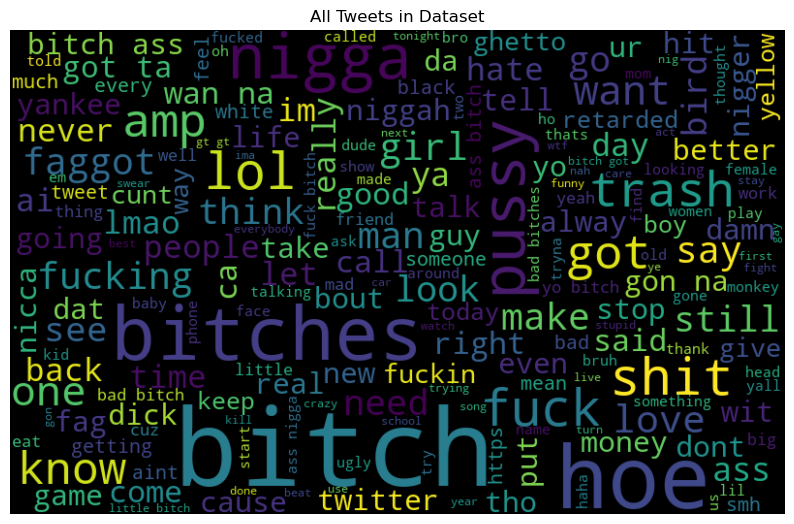

In [44]:
# Try out a word cloud for fun
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_tokens = " ".join(sum(cleaned_df['cleaned_tweet'].tolist(), []))
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_tokens)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('All Tweets in Dataset')
plt.axis('off')
plt.show()

Looks like there is plenty of offensive words used throughout this dataset. 'Bitch' and 'bitches' appear to be fan favorites here. Let's make a TfidfVectorizer for our dataset and see what it tells us.

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens together to get TfidfVectorizer to work
cleaned_df['joined_text'] = cleaned_df['cleaned_tweet'].apply(lambda tokens: ' '.join(tokens))

# Create TfidfVectorizer and fit to text data
t_vectorizer = TfidfVectorizer(use_idf=True)
X = t_vectorizer.fit_transform(cleaned_df['joined_text'])

# Convert matrix for visual purposes
X_dense = X.toarray()
print("Shape of matrix:", X_dense.shape)
print("Size of vocabulary:", len(t_vectorizer.vocabulary_))

# Let's check out the features and their TF-IDF values
print("Feature names:", t_vectorizer.get_feature_names_out())
print("TF-IDF matrix:\n", X_dense)

Shape of matrix: (24783, 26426)
Size of vocabulary: 26426
Feature names: ['aa' 'aaaaaaaaand' 'aaadontplayy' ... 'zzzentropy' 'zzzquil' 'zzzzzz']
TF-IDF matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In our data matrix that we created, the size of the vocabulary comes out to 26,426. This represents the number of features our TfidfVectorizer is using, which is essentially all the unique words left over after the preprocessing of the original text data. I tried to print out the values of the TF-IDF matrix, but there's so many features that the output needs to be cleaned up to gain any information from it. Let's try to grab the top 5 most important features in this TfidfVectorizer.

In [50]:
# Make dataframe so we can see scores of top 5 most important features
tfv_df = pd.DataFrame({'Feature': t_vectorizer.get_feature_names_out(), 'Score': X.mean(axis=0).A1})
top_features = tfv_df.nlargest(5, 'Score')
print(top_features)

       Feature     Score
2215     bitch  0.046160
2220   bitches  0.023503
10215     hoes  0.020572
13348     like  0.018836
18196    pussy  0.018584


The top five features in this TfidfVectorizer that is for the entire dataset are the words of 'bitch', 'bitches', 'hoes', 'like', and 'pussy'. I personally would not classify the word 'like' as offensive, but it is a very commonly used word in this dataset. So, it shows up as a top feature. In hindsight, I probably should have added 'like' to the list of stop words that would be removed to avoid this. If we cross reference this output with the word cloud image that was generated above, we can see that the words 'bitch' and 'bitches' dominate the dataset.

### Feature Ranking and Knowledge Generation

The previous step was a TfidfVectorizer for the entire dataset, but now we just want to take a look at the tweets that are classified as "hate speech". These are the entries that have a value of 0 in the `class` column of our dataset. So, let's take that subset of entries and create another TfidfVectorizer. Then, we'll grab the five most important features and the five least important features for it.

In [54]:
# Make subset of hate speech entries
hate_speech_df = cleaned_df[cleaned_df['class'] == 0]
print(hate_speech_df.head())

      Id  count  hate_speech  offensive_language  neither  class  \
85    85      3            2                   1        0      0   
89    90      3            3                   0        0      0   
110  111      3            3                   0        0      0   
184  186      3            3                   0        0      0   
202  204      3            2                   1        0      0   

                                         cleaned_tweet  \
85                     [whalelookyhere, queer, gaywad]   
89   [alsarabsss, hes, beaner, smh, tell, hes, mexi...   
110  [devilgrimz, vigxrarts, fucking, gay, blacklis...   
184  [markroundtreejr, lmfaoooo, hate, black, peopl...   
202                 [nochillpaz, least, nigger, lmfao]   

                                           joined_text  
85                         whalelookyhere queer gaywad  
89          alsarabsss hes beaner smh tell hes mexican  
110  devilgrimz vigxrarts fucking gay blacklisted h...  
184  markround

Now that we have all the entries that are classified as hate speech, let's make a TfidfVectorizer for them.

In [56]:
# Join tokens together to get TfidfVectorizer to work
hate_speech_df['joined_text'] = hate_speech_df['cleaned_tweet'].apply(lambda tokens: ' '.join(tokens))

# Create TfidfVectorizer and fit to hate speech text data
hate_speech_t_vectorizer = TfidfVectorizer(use_idf=True)
hate_speech_X = hate_speech_t_vectorizer.fit_transform(hate_speech_df['joined_text'])

# Convert matrix for visual purposes
hate_speech_X_dense = hate_speech_X.toarray()
print("Shape of matrix:", hate_speech_X_dense.shape)
print("Size of vocabulary:", len(hate_speech_t_vectorizer.vocabulary_))

# Let's check out the features and their TF-IDF values
print("Feature names:", hate_speech_t_vectorizer.get_feature_names_out())
print("TF-IDF matrix:\n", hate_speech_X_dense)

Shape of matrix: (1430, 3990)
Size of vocabulary: 3990
Feature names: ['aa' 'aaaaaaaaand' 'aamaadmiparty' ... 'zooyorkinit' 'zwaaad' 'zzzzzz']
TF-IDF matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


C:\Users\jonmi\AppData\Local\Temp\ipykernel_23896\3894428196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hate_speech_df['joined_text'] = hate_speech_df['cleaned_tweet'].apply(lambda tokens: ' '.join(tokens))


As expected, the data matrix for this vectorizer is way smaller than our initial one. This vectorizer consists of only 1,430 rows and 3,990 features. Let's grab the most important and least important features for this vectorizer.

In [58]:
# Grab five most important features
# Make dataframe so we can see scores of top 5 most important features
hate_speech_tfv_df = pd.DataFrame({'Feature': hate_speech_t_vectorizer.get_feature_names_out(), 'Score': hate_speech_X.mean(axis=0).A1})
hate_speech_top_features = hate_speech_tfv_df.nlargest(5, 'Score')
print(hate_speech_top_features)

     Feature     Score
1116  faggot  0.035481
338    bitch  0.027853
1988    like  0.020906
2378   nigga  0.020308
181      ass  0.019992


Due to the nature of this output, I am not going to write these words out to explain what they are. But, you can see what the five most important features for this vectorizer are. Now, let's check out the five least important features.

In [60]:
# Grab five least important features
hate_speech_bottom_features = hate_speech_tfv_df.nsmallest(5, 'Score')
print(hate_speech_bottom_features)

                     Feature     Score
2651                 pontiac  0.000141
3258               sprinkler  0.000141
3646  tweetlikepontiacholmes  0.000141
2792                 rapists  0.000164
3979                zigeuner  0.000164


The five least important features for the hate speech entries are the words of 'pontiac', 'sprinkler', 'tweetlikepontiacholmes', 'rapists', and 'zigeuner'. It seems like 'tweetlikepontiacholmes' is actually a user name. How would the order of importance for these features change if I removed all user names during the preprocessing step? Now that we've looked at the most and least important features for classifying tweets as hate speech, let's look at a word map for this subset of the data.

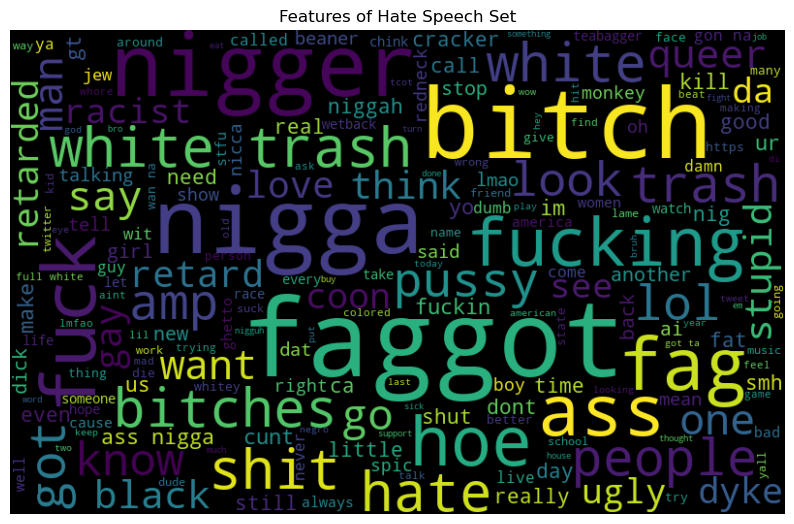

In [62]:
# Generate word map for hate speech tweets
all_tokens = " ".join(sum(hate_speech_df['cleaned_tweet'].tolist(), []))
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_tokens)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Features of Hate Speech Set')
plt.axis('off')
plt.show()

If we cross reference this word map with the output from a couple cells above, we can see that the same important features are front and center in this image.

### Classification

I am going to use a logistical regression classifier and evaluate its performance using its accuracy score. By using the TfidfVectorizer previously, we have converted the text data into a format suitable for the classifier. So, let's try to classify based on this vectorized text data.

In [67]:
# Import libraries
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

# Set target 
y = cleaned_df['class'].values

# Initialize logistic regression classifier and 5-fold cross validation
lr_model = LogisticRegression()
skf_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store future results
accuracies = []

In [68]:
# Evaluate accuracy score for each fold
for train_index, test_index in skf_cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    lr_model.fit(X_train, y_train)

    # Make predictions
    y_pred = lr_model.predict(X_test)

    # Calculate metrics and add to list
    accuracy = accuracy_score(y_test, y_pred)  
    accuracies.append(accuracy)

Accuracy score for each fold: [0.8928787573128909, 0.8973169255598143, 0.8936856969941497, 0.895682001614205, 0.9001210653753027]
Mean accuracy: 0.8959368893712725


Text(0.5, 1.0, 'Logistic Regression Classifier Accuracy by Fold')

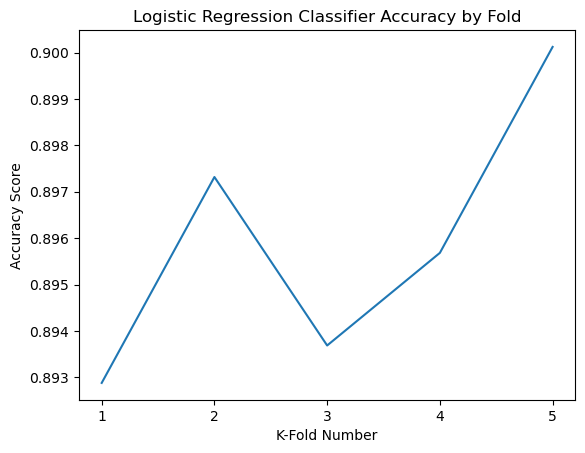

In [69]:
# Output accuracy results
print("Accuracy score for each fold:", accuracies)
print("Mean accuracy:", np.mean(accuracies))

# Plot accuracy results
plt.plot(range(1, 6), accuracies)
plt.xlabel('K-Fold Number')
plt.ylabel('Accuracy Score')
plt.xticks(np.arange(1, 6, step=1))
plt.title('Logistic Regression Classifier Accuracy by Fold')

We can see that the logistical regression classifier hovers around an accuracy score of a little over 89%. Across all five folds, the average score is 89.59% with its highest score coming from the Fold #5 at 90.01%. Unfortunately, this plot is a little misleading and suggests a big jump in accuracy score from Fold #4 to Fold #5, but it is really only an increase of 0.0044%. Just out of curiousity, let's see what happens if we double the amount of folds. Did the classifier just "get lucky" with these initial five folds?

In [71]:
# New K Fold with 10 splits
skf_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store future results
accuracies = []

# Evaluate accuracy score for each fold
for train_index, test_index in skf_cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    lr_model.fit(X_train, y_train)

    # Make predictions
    y_pred = lr_model.predict(X_test)

    # Calculate metrics and add to list
    accuracy = accuracy_score(y_test, y_pred)  
    accuracies.append(accuracy)

Accuracy score for each fold: [0.8935054457442517, 0.8943122226704316, 0.8971359419120614, 0.9027441485068604, 0.9007263922518159, 0.8857949959644875, 0.8987086359967716, 0.9003228410008071, 0.8979015334947539, 0.9003228410008071]
Mean accuracy: 0.8971474998543048


Text(0.5, 1.0, 'Logistic Regression Classifier Accuracy by Fold')

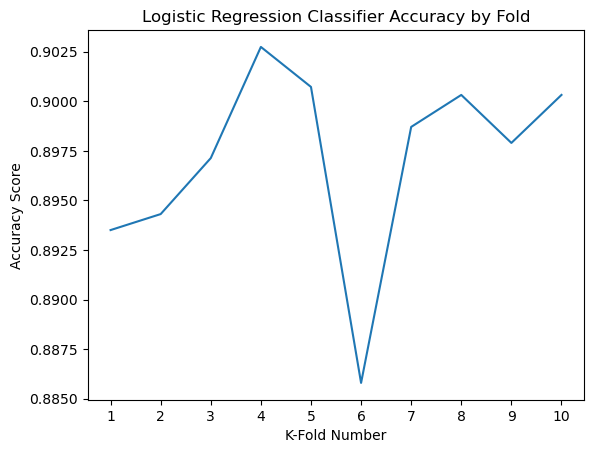

In [72]:
# Output accuracy results
print("Accuracy score for each fold:", accuracies)
print("Mean accuracy:", np.mean(accuracies))

# Plot accuracy results
plt.plot(range(1, 11), accuracies)
plt.xlabel('K-Fold Number')
plt.ylabel('Accuracy Score')
plt.xticks(np.arange(1, 11, step=1))
plt.title('Logistic Regression Classifier Accuracy by Fold')

Not too sure what happened with Fold #6, but there is quite a drop in accuracy score for that particular one. Fold #6 yielded an accuracy score of 88.58%, which is 1.14% lower than the average accuracy score across all ten folds and is by far the lowest of all the folds processed. The average accuracy score for these ten folds is 89.71%, which is a little better than the initial cross validation we did with five folds. I would imagine the more folds conducted and evaluated, a more "true" sense of this model's performance would come to light. I could go into fine tuning some of the hyper parameters for this logistic regression classifier to improve its performance even more, but we'll save that for another day. 

### Unsupervised Learning

I am going to be using K-Means clustering method for the text data. I am going to only use two clusters to represent a tweet being classified as hateful/offensive or not.

In [126]:
# Import libraries
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Reduce dimensionality of data
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())

# Fit K-Means to data
kmeans = KMeans(n_clusters=2, n_init=5, max_iter=500, random_state=42)
kmeans.fit(X)

KMeans(max_iter=500, n_clusters=2, n_init=5, random_state=42)

In [128]:
# Let's see what PCA came up with
feature_names = t_vectorizer.get_feature_names_out()
components = pca.components_
pca_feature_names = pd.DataFrame(components, columns=feature_names)
print("PCA Component Feature Names and Scores:")
print(pca_feature_names)

PCA Component Feature Names and Scores:
         aa  aaaaaaaaand  aaadontplayy  aaahhhhh   aahahah   aaliyah  \
0 -0.000233    -0.000066     -0.000079 -0.000060 -0.000065 -0.000144   
1  0.000254     0.000046      0.000034  0.000039  0.000052 -0.000218   

   aaliyahhhm  aamaadmiparty      aamu       aan  ...      zuko    zulema  \
0   -0.000098      -0.000047 -0.000089 -0.000039  ... -0.000330 -0.000137   
1    0.000051       0.000024  0.000072  0.000032  ... -0.000115 -0.000085   

       zulu    zwaaad  zwengersierra    zwithr  zzachbarness    zzzentropy  \
0 -0.000095 -0.000149       0.000720 -0.000095      0.001067  2.794356e-04   
1 -0.000006  0.000082      -0.000047  0.000185      0.000159  2.066271e-07   

    zzzquil    zzzzzz  
0 -0.000066 -0.000077  
1  0.000029  0.000041  

[2 rows x 26426 columns]


In [130]:
# Extract results of clustering
results = pd.DataFrame()
results['tweet'] = cleaned_df['cleaned_tweet']
results['class'] = kmeans.labels_

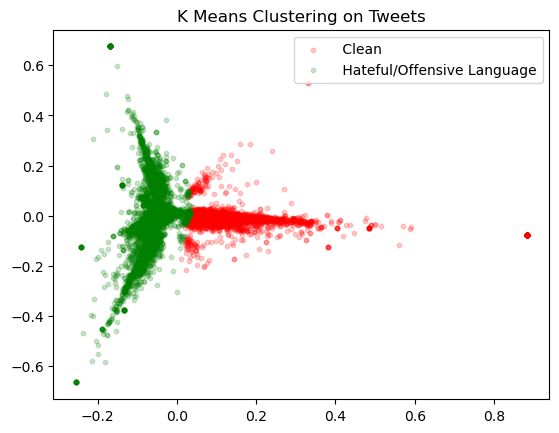

In [132]:
# Plot clusters 
colors = ['red', 'green'] 
cluster = ['Clean', 'Hateful/Offensive Language'] 
for i in range(2): 
    plt.scatter(reduced_data[kmeans.labels_ == i, 0], reduced_data[kmeans.labels_ == i, 1], s=10, alpha=0.2, color=colors[i], label=f' {cluster[i]}') 
plt.title('K Means Clustering on Tweets')
plt.legend()
plt.show()

In our plot, the red circles represent the tweets that do not contain hateful or offensive language and the green circles represent the tweets that do. We can see a pretty clear distinction in the clusters around the value of 0 on the x-axis. There is an interesting pattern in the y-values of the clean tweets where they stay around the value of 0 on the y-axis, while the hateful/offensive (red) tweets are pretty scattered up and down the y-axis. Also, we do not really see any overlapping of the clusters into each other. This means the K-Means model had a fairly easy time classifying the tweets as either containing hateful/offensive language or not. I modified the alpha value of the scatter plot to ensure that we would be able to see if the green dots were covering up the red ones. Let's see what the clustering looks like if we set the number of clusters to be three, which is the same number of classification options for the target variable. I would expect to see the green hateful/offensive cluster get divided up into two clusters - one representing hateful tweets and another representing the offensive tweets.

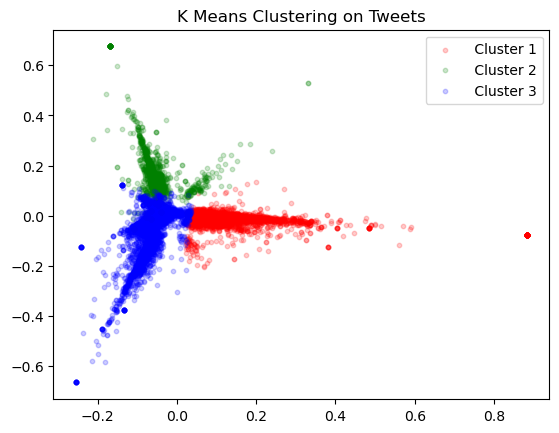

In [138]:
# Try out three clusters
kmeans = KMeans(n_clusters=3, n_init=5, max_iter=500, random_state=42)
kmeans.fit(X)

# Extract results of clustering
results = pd.DataFrame()
results['tweet'] = cleaned_df['cleaned_tweet']
results['class'] = kmeans.labels_

# Plot clusters 
colors = ['red', 'green', 'blue'] 
cluster = ['Cluster 1', 'Cluster 2', 'Cluster 3'] 
for i in range(3): 
    plt.scatter(reduced_data[kmeans.labels_ == i, 0], reduced_data[kmeans.labels_ == i, 1], s=10, alpha=0.2, color=colors[i], label=f' {cluster[i]}') 
plt.title('K Means Clustering on Tweets')
plt.legend()
plt.show()

As expected, it looks like the cluster representing the "clean" tweets appears rather unchanged, which are the red circles. The original cluster representing the hateful/offensive tweets has been broken up into two different clusters, which are the green and blue circles. Interesting to see how the division of clustering for the hateful/offensive tweets is pretty dependent on if the y-value is more or less than 0.1. Also, it looks like the green cluster has one outlier tweet at around (0.3, 0.5) that looks like it had the possibility of joining the red cluster.

### Conclusion

### Feature Exploration

We started this task by doing some exploratory data analysis on the collection of tweets. We learned that the overwhelming majority (~77%) of tweets in this dataset had been given a classification of containing offensive language. Also, we saw that there was quite a lot of work to do in cleaning up the text data of the `tweet` column.

### Feature Preprocessing

Because of my prior knowledge of Twitter, I knew we were going to have to deal with a variety of symbols, numbers, and user names in the text data that "muddied" it. Ultimately, I decided to remove all symbols, numbers, and URL links, but keep the user names included in the tweets. Removing these kinds of text from the dataset could lead to a possible loss of context for a data scientist, but that trade off between performance and speed will always exist.

### Feature Extraction and Improvements

Through the use of the Natural Language Toolkit (NLTK), we removed stop words, symbols, URLs, punctuation, and capitalization from our text data. Due to my prior knowledge of Twitter, I added some of my own stop words to the default NLTK list, like 'rt' and 'retweet'. After cleaning up the tweets and removing all the "fluff", we tokenized the text data in preparation for using our classification models.

### Feature Ranking

With the help of a TfidfVectorizer, we were able to see which features (tokens) were most and least important in the dataset. In the total dataset, the top five most important and frequently appearing features were the words of 'bitch', 'bitches', 'hoes', 'like', and 'pussy'. The feature 'like' is certainly not offensive by itself, but it is a commonly use word in the English language, which is probably why the TfidfVectorizer saw it as very important. Word maps also enabled us to visualize the more prevalent features in the dataset.

### Supervised Learning

We used a Logistical Regression model that yielded an average accuracy score of 89.59% through the first five folds and 89.71% through the first ten folds. Future work to improve this model's accuracy could include the fine-tuning of the hyperparameters with a grid search to find the optimal configuration.

### Unsupervised Learning

We used a K-Means clustering method to see how the text data should be organized. Our first iteration used only two clusters and we saw a solid division between the clean tweets and the offensive/hateful tweets. When we increased the number of clusters to three, we saw the original hateful/offensive cluster get split up, while the cluster representing the clean tweets remained unchanged. There was no overlapping of the clusters that I could see, so the model seemed to have a pretty easy time classifying the tweets.